Let $d \in \mathbb{N}$.  Newman(1964) polinomial is

$$
N(x) = \prod_{i=1}^{d-1} ( x - a_n^i ) \quad \quad \quad a_n = \exp \left\{ - \frac{1}{\sqrt{d}} \right\}
$$

We use it to construct a rational function $r_n$ that uniformly approximates $|x|$ inside $[-1,1]$:

$$
r_n(x) = x \, \frac{N(x) - N(-x)}{N(x) + N(-x)} = \frac{p(x)}{q(x)}
$$

Both the numerator and the denominator have degree $d$. We have


$$
\sup_{x \in [-1,1]} \; \big| |x| - r_n(x) \big| \; \leq 3 e^{-\sqrt{d}}
$$

In [48]:
using Pkg
using LinearAlgebra
using Symbolics
using MultivariatePolynomials
using DynamicPolynomials
using HomotopyContinuation             # para plots
using Distributions
using Random
using Plots  

# Função que arredonda polinômios

function roundp(p)
      if p isa AbstractPolynomialLike
          cs = coefficients(p)
          ms = monomials(p)
          return isempty(cs) ? zero(p) : sum(round(c; digits=1) * m for (c, m) in zip(cs, ms))
      elseif p isa Number
          return round(p; digits=2)
      elseif p isa AbstractArray
          return map(roundp, p)
      else
          error("Unsupported type in roundp: $(typeof(p))")
      end
  end
  # -----

function expand_vector(v) 
    return [ModelKit.expand(v[i]) for i in 1:length(v)] end   

expand_vector (generic function with 1 method)

# Visualization

In [ ]:

function f(x)
 return abs(x)
end  

function N(x,d) 
  a = exp( - 1 / sqrt(d) ) 
 return prod(   [ x + a^k  for k in 1:d-1   ]  )   
end

function r(x,d)
  return  x *(   N(x,d) - N(-x,d)   )/(  N(x,d) + N(-x,d)  )
end  



0.0

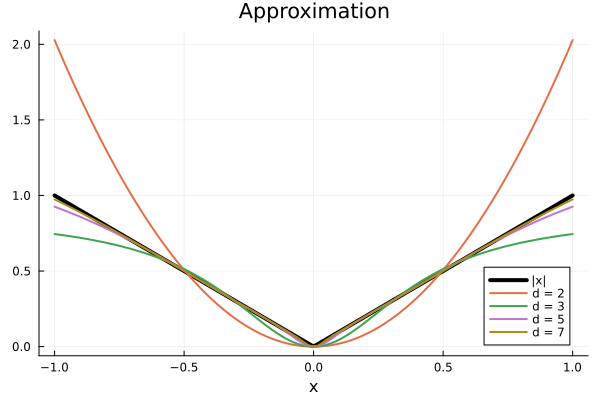

In [121]:
xs = range(-1, 1; length=200)
plot(xs, f.(xs); label="|x|", xlabel="x", title="Approximation" , lw=4, color=:black)

for d in [2,3,5,7]
 plot!(xs, r.(xs , d); label="d = $d", lw=2)
end 

display(current())

# LASSO

We are using a polinomial functio to approximate the $l^1$ norm and solve

$$
\min_{\beta} \; (y - \boldsymbol{X} \beta)' (y - \boldsymbol{X} \beta) \quad \quad s.t.  \quad \sum_{i=1}^k \frac{p(\beta_i)}{q( \beta_i)} \leq 1
$$

Where 

$$
p(\beta_i) = \beta_i N ( \beta_i) -  \beta_i N ( -\beta_i) \quad \quad q(\beta_i) = N ( \beta_i) +  N ( -\beta_i)
$$
  
Let $R( \beta) = \sum_{i=1}^k \frac{p(\beta_i)}{q( \beta_i)}$. The Lagrangean is

$$
\mathcal{L}
=
{ \textstyle \frac{1}{2}} (y - \boldsymbol{X} \beta)' (y - \boldsymbol{X} \beta)
+
\lambda \left[ R( \beta)  - 1 + s^2 \right] = 0 
$$

The FOC of the Lagrangean is

$$
-\boldsymbol{X}'( y - \boldsymbol{X} \beta)
+
\lambda 
\sum_{i=1}^k q(\beta_i)^{-1} \nabla p( \beta_i) - q(\beta_i)^{-2} \nabla q(\beta_i) = 0
$$

To turn this into a polinomial system, we must multiply it by $ Q_1( \beta) = \prod_{j=1}^k q(\beta_j)^2$. The system with the KT conditions is

$$
\begin{split}
& Q_2( \beta)  \big\{ \boldsymbol{X}'( y - \boldsymbol{X} \beta)
+
\lambda \nabla R( \beta) \big\} = 0  \\

& Q_1( \beta)(R( \beta)  + s^2 - 1) = 0 \\

& \lambda s = 0

\end{split}
$$

Where $Q_1( \beta) = \prod_{j=1}^k q(\beta_j)$


In [266]:
d = 5
a = exp( - 1 / sqrt(d) ) 
k = 2
n = 1000

using Random

Random.seed!(126)

X = rand(n, k)
beta_0 = [ 2, 0.1 ]


y = X* beta_0 + rand(Normal(0,1), n) ; 

@var β[1:k] λ s

function N(b) 
 return prod(   [ b + a^k  for k in 1:d-1   ]  )   
end


R_terms = [    β[i]*(   N(β[i]) - N( -β[i] )   )/ (  N(β[i]) + N(-β[i])  )     for i in 1:k    ] 
Q1 = prod(  [  N(β[i]) + N(-β[i])  for i in 1:k ]   )
Q2 = prod(  [ ( N(β[i]) + N(-β[i]) )^2  for i in 1:k ]   ) 


p = [     β[i]*(   N(β[i]) - N( -β[i] )   ) for i in 1:k     ]
q = [        N(β[i]) + N( -β[i] )    for i in 1:k     ]

∇p = [   [ differentiate(p[j], β[i]) for i in 1:k]  for j in 1:k  ]
∇q = [   [ differentiate(q[j], β[i]) for i in 1:k]  for j in 1:k  ]

q_minus = [    prod(  q[j]^2 for j in 1:k if j ≠ i )   for i in 1:k ]

Q2DR = sum( [ (q[i]*∇p[i]* q_minus[i]  + p[i]*∇q[i]*q_minus[i]       )  for i in 1:k ] )


2-element Vector{Expression}:
 ((0.639407319161897 - β₂)*(0.261416388017453 - β₂)*(0.408841719797804 - β₂)*(0.167151551847226 - β₂) + (0.639407319161897 + β₂)*(0.261416388017453 + β₂)*(0.408841719797804 + β₂)*(0.167151551847226 + β₂))^2*((0.639407319161897 - β₁)*(0.261416388017453 - β₁)*(0.408841719797804 - β₁)*(0.167151551847226 - β₁) + (0.639407319161897 + β₁)*(0.261416388017453 + β₁)*(0.408841719797804 + β₁)*(0.167151551847226 + β₁))*(((0.261416388017453 - β₁)*(0.408841719797804 - β₁)*(0.167151551847226 - β₁) + (0.261416388017453 + β₁)*(0.408841719797804 + β₁)*(0.167151551847226 + β₁) + (0.639407319161897 - β₁)*(0.261416388017453 - β₁)*(0.167151551847226 - β₁) + (0.639407319161897 - β₁)*(0.261416388017453 - β₁)*(0.408841719797804 - β₁) + (0.639407319161897 - β₁)*(0.408841719797804 - β₁)*(0.167151551847226 - β₁) + (0.639407319161897 + β₁)*(0.261416388017453 + β₁)*(0.167151551847226 + β₁) + (0.639407319161897 + β₁)*(0.261416388017453 + β₁)*(0.408841719797804 + β₁) + (0.639407319161897

In [267]:
# first part: s = 0      . é possível verificar que isso será a condição verdadeira vendo que o beta_ols está fora do conjunto restrição

eqA = expand_vector( Q2* X' * ( y - X*β ) + λ*Q2DR  ) 
eqB = sum( [Q1*r for r in R_terms ]  ) - Q1

F = vec( [eqA ; eqB ] ) 

vars = [ β ; λ  ]

F_sys = System(F; variables=vars)

result = solve(F_sys ; start_system = :total_degree)

complex_sols_1 = solutions(result)

tol = 10^(-5)
# display( count(u -> all(abs.(imag.(u)) .< tol ), complex_sols_1) ) = 6

S_1 = [ real(s) for s in complex_sols_1 if all(abs.(imag.(s)) .< tol)] ; 

Tracking 2312 paths... 100%|████████████████████████████| Time: 0:00:10
                   # paths tracked: 2312
   # non-singular solutions (real): 72 (2)
       # singular endpoints (real): 32 (0)
          # total solutions (real): 104 (2)


In [268]:
# second part: lambda = 0  nem preciso fazer esse

eqA = expand_vector( Q2* X' * ( y - X*β )  ) 
eqB = sum( [Q1*r for r in R_terms ]  ) + Q1*(s^2 -1 )

F = vec( [eqA ; eqB ] ) 

vars = [ β ; s  ]

F_sys = System(F; variables=vars)

result = solve(F_sys ; start_system = :total_degree)

complex_sols_2 = solutions(result)

tol = 10^(-5)
# display( count(u -> all(abs.(imag.(u)) .< tol ), complex_sols_1) ) = 0   nenhuma solução no interior do conjunto

S_2 = [ real(s) for s in complex_sols_2 if all(abs.(imag.(s)) .< tol)] ; 


Tracking 2890 paths... 100%|████████████████████████████| Time: 0:00:11
                   # paths tracked: 2890
   # non-singular solutions (real): 2 (0)
       # singular endpoints (real): 6 (0)
          # total solutions (real): 8 (0)


In [269]:
S = [S_1; S_2]


# verificar se todas satisfazem a restrição

function R_num(b)
  return  sum( [    b[i]  *(   N(b[i]) - N(-b[i])   )/(  N(b[i]) + N(-b[i])  )     for i in 1:k    ] ) 
end 

S = [  s[1:2] for s in S if R_num(s) -1 <= tol ]


function Squares(b)
  return  (y - X*b)'*(y - X*b)
end 

OLS = inv(X' *X ) * X' * y
LASSO = S[  argmin([Squares([x[1], x[2]]) for x in S])  ]


2-element Vector{Float64}:
 0.8150265383381705
 0.20597495463009313

In [270]:
S_1

2-element Vector{Vector{Float64}}:
 [-0.7065422012994942, -0.29942150875145235, 170.59403751742784]
 [0.8150265383381705, 0.20597495463009313, -62.6444027951323]

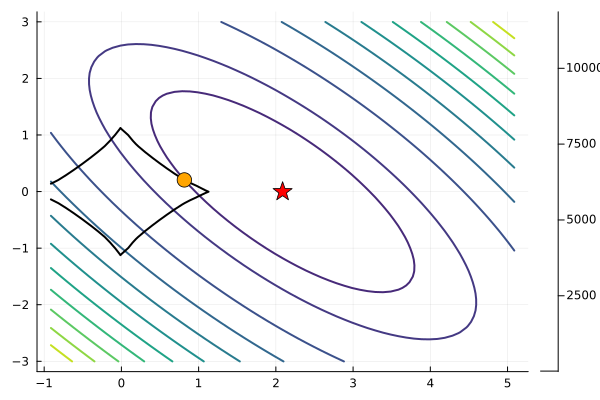

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different levels share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with differe

In [271]:
x_grid = [ OLS[1] + i for i in -3: 0.1 :3 ]
y_grid = [ OLS[2] + i for i in -3: 0.1 :3 ]    

Z = [Squares([xi, yi]) for yi in y_grid, xi in x_grid]
Z2 = [R_num([xi, yi]) for yi in y_grid, xi in x_grid]

L = range(minimum(Z), maximum(Z), length=12) 
L = sort(vcat(collect(L), [Squares(  [ LASSO[1], LASSO[2]  ] )])) 

contour(x_grid, y_grid, Z, levels= L, colormap = :viridis, linewidth=2)

# ponto a destacar
contour!(x_grid, y_grid, Z2, levels=[1], color=:black, linewidth=2, label="x² - y³ = 0")

scatter!([LASSO[1]], [LASSO[2]], color=:orange, markersize=8, label="")
scatter!([OLS[1]], [OLS[2]], color=:red, markersize=10, label="" , marker =:star5)
